# Analyzing external simulations with pyEXP
In this tutorial, we will compute a BFE from the particle data from Halo 364 of the symphony cosmological simulation.

The data can be downloaded from this link: https://drive.google.com/file/d/1zOBgkGy3k8dwfPOldCEdNxLAHdieiXTG/view?usp=sharing


In [57]:
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d, BSpline, splrep
import matplotlib.pyplot as plt
import pyEXP
from matplotlib.colors import LogNorm
import EXPtools
import makemodel
from inspect import getmembers, isfunction
import pickle
#plt.style.use('../../MW_viz/matplotlib.mplstyle')


In [85]:
DATAPATH = "../data/"
halo = np.load(DATAPATH + "Halo719/Halo719_{:03d}.npy".format(220))
h = {'position': halo['x'], 'velocity': halo['v']}

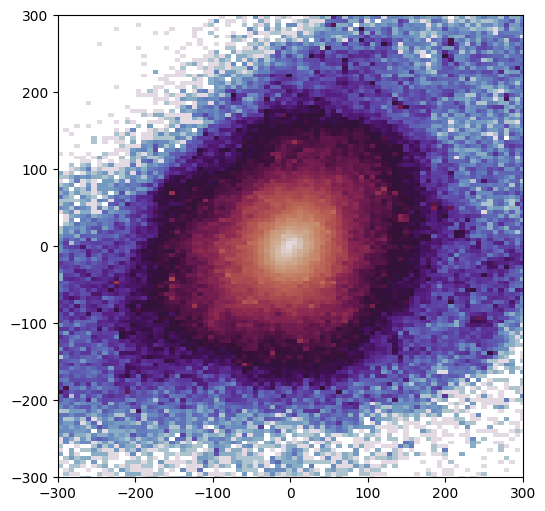

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.hist2d(h['position'][:,0], h['position'][:,1], bins=200, norm=LogNorm(), cmap='twilight');
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
plt.Circle((0,0), 300, color='w', ls='--')

## EXP units and parameters

In [4]:
# EXP units and parameters 
Renc = 150 # Maximum radius to build the basis
Rin = 0.5
Rbins = 1000 # Number of bins 
rvals_lin = np.linspace(Rin, Renc, Rbins) # Choosing bins
rvals_log = np.logspace(np.log10(Rin), np.log10(Renc), Rbins) # Choosing bins

nparticles = len(h['position'])
print(nparticles)
mp = 402830.0 # Msun 

480642


In [5]:
rhalo = np.sqrt(np.sum(h['position']**2, axis=1))
enc = np.where(rhalo<rvals_lin[-1])
Menc = len(enc[0])
Mtot = nparticles 
Mfrac = Menc/Mtot
print(Rbins, Menc, Mtot, Mfrac)

1000 288236 480642 0.599689581850941


In [6]:
# Now we need to specify the type of basis that we want to use. For this we will use the profiles included in makemodel.

In [7]:
getmembers(makemodel, isfunction)

[('empirical_density_profile',
  <function makemodel.empirical_density_profile(rbins, pos, mass, smooth_length=0.0)>),
 ('hernquist_halo', <function makemodel.hernquist_halo(r, a)>),
 ('makemodel',
  <function makemodel.makemodel(func, M, funcargs, rvals=array([1.00000000e-02, 1.00693515e-02, 1.01391839e-02, ...,
       9.86272669e+03, 9.93112617e+03, 1.00000000e+04]), pfile='', plabel='', verbose=True)>),
 ('plummer_density',
  <function makemodel.plummer_density(radius, scale_radius=1.0, mass=1.0, astronomicalG=1.0)>),
 ('powerhalo',
  <function makemodel.powerhalo(r, rs=1.0, rc=0.0, alpha=1.0, beta=1e-07)>),
 ('powerhalorolloff',
  <function makemodel.powerhalorolloff(r, rs=1.0, rc=0.0, alpha=1.0, beta=1e-07)>),
 ('splrep',
  <function scipy.interpolate._fitpack_py.splrep(x, y, w=None, xb=None, xe=None, k=3, task=0, s=None, t=None, full_output=0, per=0, quiet=1)>),
 ('twopower_density_withrolloff',
  <function makemodel.twopower_density_withrolloff(r, a, alpha, beta, rcen, wcen)>)]

In [8]:
r_emp_lin, rho_emp_lin = makemodel.empirical_density_profile(rvals_lin, h['position'], mass=np.ones(len(rhalo))*mp)
r_emp_log, rho_emp_log = makemodel.empirical_density_profile(rvals_log, h['position'], mass=np.ones(len(rhalo))*mp)

r_emp_lin_smooth, rho_emp_lin_smooth = makemodel.empirical_density_profile(rvals_lin, h['position'], mass=np.ones(len(rhalo))*mp, 
                                                                           smooth_length=0.8)
r_emp_lin_oversmooth, rho_emp_lin_oversmooth = makemodel.empirical_density_profile(rvals_lin, h['position'], mass=np.ones(len(rhalo))*mp, 
                                                                           smooth_length=1.5)

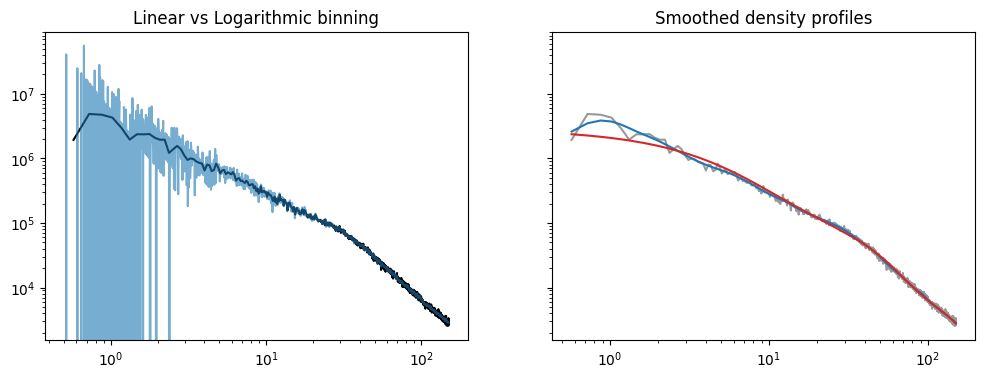

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].set_title('Linear vs Logarithmic binning')
ax[0].loglog(r_emp_lin, rho_emp_lin, c='k')
ax[0].loglog(r_emp_log, rho_emp_log, c='C0', alpha=0.6)

ax[1].set_title('Smoothed density profiles')
ax[1].loglog(r_emp_lin, rho_emp_lin, c='k', alpha=0.4)
ax[1].loglog(r_emp_lin_smooth, rho_emp_lin_smooth)
ax[1].loglog(r_emp_lin_oversmooth, rho_emp_lin_oversmooth, c='C3')


In [10]:
rho_nfw = makemodel.powerhalo(rvals_lin, rs=25.0, rc=0, alpha=1, beta=2)

In [11]:
M_nfw =  np.sum(rho_nfw*Mfrac*mp)
M_emp =  np.sum(rho_emp_lin_smooth)
print(M_nfw, M_emp, M_emp/M_nfw)


124757062.36778483 95843160.58079468 0.7682383567051961


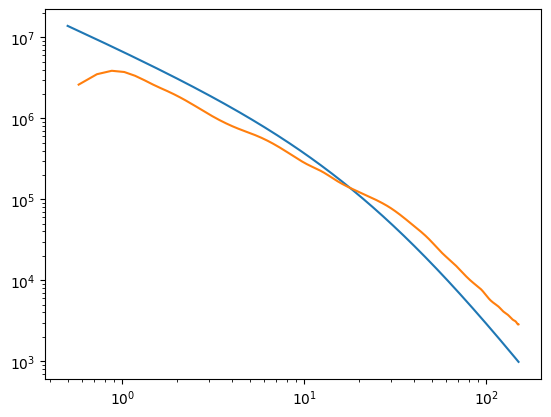

In [12]:
plt.loglog(rvals_lin, rho_nfw*Menc)
plt.loglog(r_emp_lin_smooth, rho_emp_lin_smooth)

# We will now built the basis using these two profiles

### 1. Make the model 

In [21]:
Remp, Demp, Memp, Pemp = makemodel.makemodel(makemodel.empirical_density_profile, M=Mfrac*mp*Menc,
                                             funcargs=(h['position'], np.ones(len(rhalo))*mp, 0.0), 
                                             rvals=rvals_lin,
                                             pfile='mwest719_220_empirical.txt')

! Scaling: R= 149.92517517517518   M= 69630022043.22485
0.9999999999999999 0.6000035724127868 0.6000035724127868 0.6000035724127868


In [22]:
Rnfw, Dnfw, Mnfw, Pnfw = makemodel.makemodel(makemodel.powerhalo, M=Mfrac*mp*Menc,
                                 funcargs=([25.0, 0, 1, 2]),rvals=rvals_lin,
                                 pfile='mwest719_220_nfw.txt')

! Scaling: R= 150.0   M= 69630022043.22485
1.0 325769.4827118314 325769.4827118314 325769.4827118314


In [23]:
Remp_smooth, Demp_smooth, Memp, Pemp = makemodel.makemodel(makemodel.empirical_density_profile, M=Mfrac*mp*Menc,
                                                          funcargs=(h['position'], np.ones(len(rhalo))*mp, 0.8), 
                                                          rvals=rvals_lin,
                                                          pfile='mwest719_220_empirical_smooth.txt')

! Scaling: R= 149.92517517517518   M= 69630022043.22485
1.0 0.6010854756747541 0.6010854756747541 0.6010854756747541


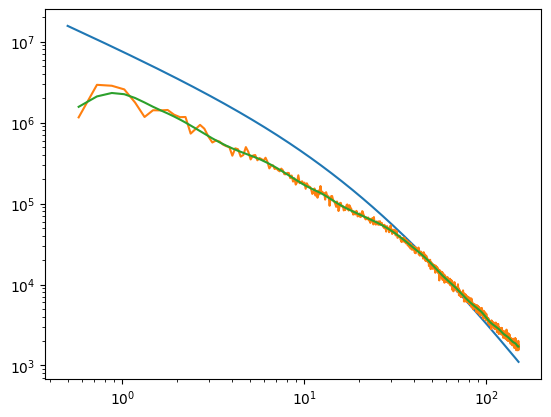

In [24]:
plt.loglog(Rnfw, Dnfw)
plt.loglog(Remp, Demp)
plt.loglog(Remp_smooth, Demp_smooth)

# Let's build the basis

In [215]:
## Discuss the parameters of the cofig herE:

In [209]:
# What will be the rmapping?
rs = 25 # Scale Length
rmax = 150 # Rmax
rmapping = rs/rmax # rmapping is relative to rmax

Object `rmapping` not found.


In [32]:
basis_config = """
id         : sphereSL
parameters :
  numr     : 1000
  rmin     : 1.0
  rmax     : 150
  Lmax     : 5
  nmax     : 10
  rmapping  : 0.16
  modelname : mwest719_220_nfw.txt
  cachename : mwest719_220_nfw.cache
"""
symphony_basis = pyEXP.basis.Basis.factory(basis_config)

---- SLGridSph::ReadH5Cache: parameter rmapping: wanted 0.16 found 25
---- SLGridSph::WriteH5Cache cache file <mwest719_220_nfw.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <mwest719_220_nfw.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <mwest719_220_nfw.cache>
Spherical::orthoTest: worst=0.0385009


In [33]:
symbasis = symphony_basis.getBasis(1.5, 2.99, 999)
EXP

In [34]:
symbasis[0][0]['density'].shape

(999,)

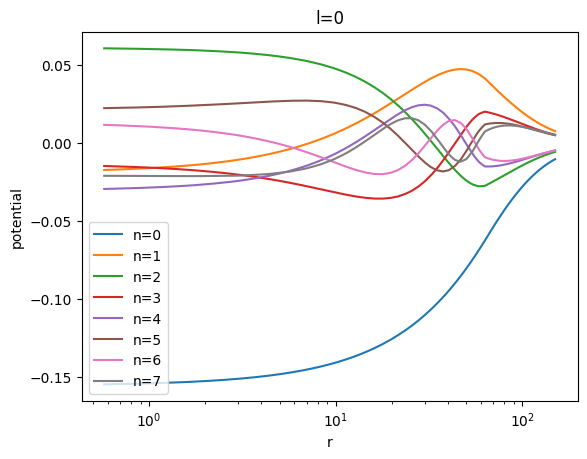

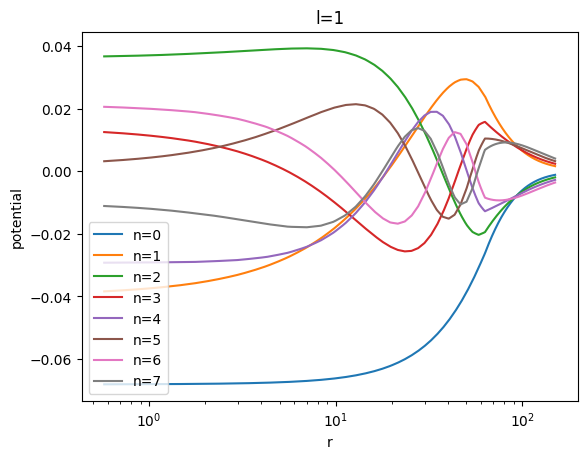

In [35]:
for l in range(2):
    for n in range(8):
        plt.semilogx(Remp, symbasis[l][n]['potential'], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('l={}'.format(l))
    plt.legend()
    plt.show()                            

## Compute coefficients

In [108]:
symphony_coef = symphony_basis.createFromArray(np.ones(nparticles), h['position'], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(symphony_coef, 'halo')
halo_coefs.add(symphony_coef)

# Compute fields

In [111]:
#EXPtools.visuals.spherical_avg_prop(symphony_basis, symphony_coef, r_emp_lin, property='dens')

In [112]:
nfw_volume = np.zeros((50, 100, 100))
empirical_volume = np.zeros((50, 100, 100))
z_sice = np.linspace(-100, 100, 50)

for i in range(len(z_sice)):
    pmin  = [-150.0, -150.0, z_sice[i]]
    pmax  = [ 150.0,  150.0, z_sice[i]]
    grid  = [  100,   100,   0]
    
    fields = pyEXP.field.FieldGenerator([0.0], pmin, pmax, grid)
    surfaces = fields.slices(symphony_basis, halo_coefs)
    nfw_volume[i] = surfaces[0.0]['dens']
    empirical_volume[i] = surfaces[0.0]['dens m=0']



(-150.0, 150.0)

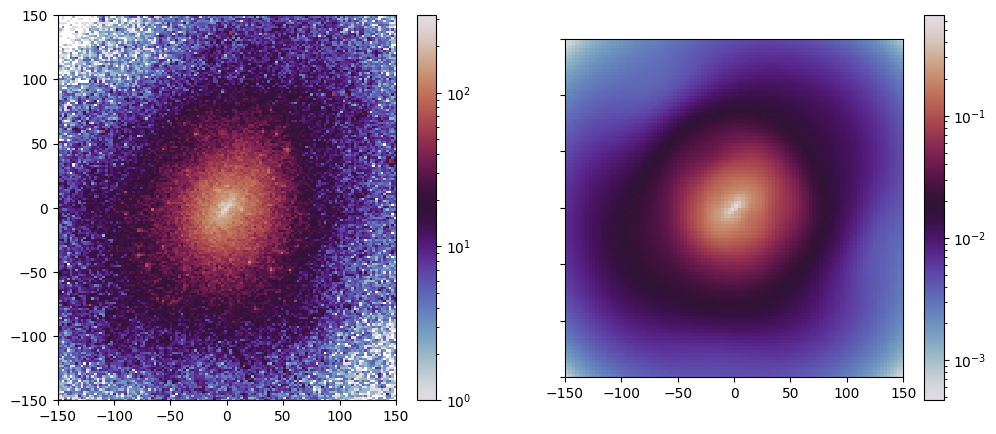

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
img1 = ax[1].imshow((np.mean(volume, axis=0)).T,  cmap='twilight', 
             origin='lower', extent=[-150, 150, -150, 150], norm=LogNorm())

img2 = ax[0].hist2d(h['position'][:,0], h['position'][:,1], bins=600, norm=LogNorm(), cmap='twilight');

ax[0].set_xlim(-150, 150)
ax[0].set_ylim(-150, 150)

fig.colorbar(img1, ax=ax[1])
fig.colorbar(img2[3], ax=ax[0])

#plt.colorbar(img)
ax[1].set_xlim(-150, 150)
ax[1].set_ylim(-150, 150)


In [ ]:
# Evaluating # 

In [147]:
def sphercial_grid(gridspecs = {'theta_bins': 90, 'phi_bins' : 180}, rgrid=10):
    arcostheta = np.linspace(-1, 1, gridspecs['theta_bins'])
    phi = np.linspace(0, 2*np.pi, gridspecs['phi_bins'])
    theta_mesh, phi_mesh = np.meshgrid(np.arccos(arcostheta), phi)

    x = rgrid  * np.sin(theta_mesh.flatten()) * np.cos(phi_mesh.flatten())
    y = rgrid  * np.sin(theta_mesh.flatten()) * np.sin(phi_mesh.flatten())
    z = rgrid  * np.cos(theta_mesh.flatten()) 
    ## TODO: fix this return to allow the user to chose what to return
    return np.array([x, y, z]).T #, theta_mesh, phi_mesh

# Compute spherical density profile with EXP 

Note, this will change with the new implementation of the pointmesh evaluation.

In [207]:
rbins = r_emp_lin_oversmooth[::10]
rho_spherical_exp = np.zeros(len(rbins))
for r in range(len(rbins)):
    xyz_sph = sphercial_grid(rgrid = rbins[r])
    rho_bin = np.zeros(len(xyz_sph))
    for i in range(len(xyz_sph)):
        rho_bin[i] = symphony_basis.getFields(xyz_sph[i][0], xyz_sph[i][1], xyz_sph[i][2])[0] 
    rho_spherical_exp[r] = np.median(rho_bin)

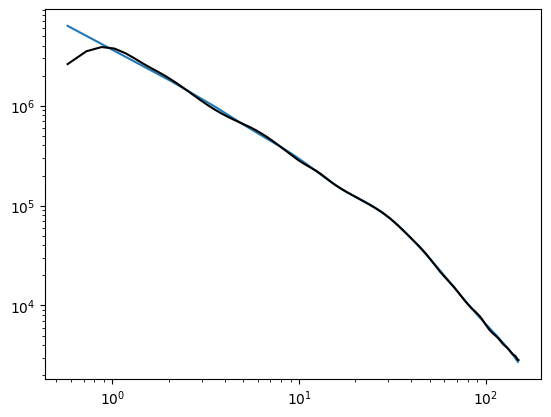

In [188]:
#fig ax = plt.subplots()
plt.loglog(rbins, rho_spherical_exp*mp)
#plt.loglog(Rnfw, Dnfw*Mfrac)
plt.loglog(r_emp_lin_smooth, rho_emp_lin_smooth, c='k')


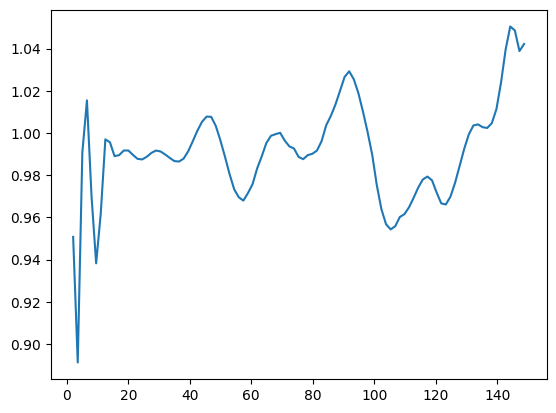

In [205]:
plt.plot(rbins[1:], rho_emp_lin_smooth[1::10][1:]/(rho_spherical_exp[1:]*mp))

In [58]:
DATA = '../data/NICO_PICKLE/'
with open(DATA+'orbits_rotated.pickle', 'rb') as f:
    orbits = pickle.load(f)

In [60]:
volume = np.zeros((11, 100, 100))
volume_mon = np.zeros((11, 100, 100))
volume_dip = np.zeros((11, 100, 100))
    
z_sice = np.linspace(-25, 25, 11)

for k in range(18):
    DATAPATH = "../data/"
    halo = np.load(DATAPATH + "Halo719/Halo719_{:03d}.npy".format(218+k))
    h = {'position': halo['x'], 'velocity': halo['v']}
    symphony_coef = symphony_basis.createFromArray(np.ones(nparticles), h['position'], time=0.0)
    halo_coefs = pyEXP.coefs.Coefs.makecoefs(symphony_coef, 'halo')
    halo_coefs.add(symphony_coef)
    times = halo_coefs.Times()
    print(times)
    
    for i in range(len(z_sice)):
        pmin  = [-150.0, -150.0, z_sice[i]]
        pmax  = [ 150.0,  150.0, z_sice[i]]
        grid  = [  100,   100,   0]
        
        fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)
        surfaces = fields.slices(symphony_basis, halo_coefs)
        volume[i] = surfaces[0.0]['dens']
        volume_mon[i] = surfaces[0.0]['dens m=0']
        volume_dip[i] = surfaces[0.0]['dens m>0']

    img = plt.imshow((np.mean(volume, axis=0)/ np.mean(volume_mon, axis=0)) - 1  , cmap='twilight', 
                 origin='lower', extent=[-150, 150, -150, 150], vmin=-1, vmax=1)
    plt.colorbar(img)
    plt.xlim(-150, 150)
    plt.ylim(-150, 150)
    #plt.plot(orbits['Halo719'][:k+1,0], orbits['Halo719'][:k+1,1], c='w')
    #plt.scatter(orbits['Halo719'][k,0], orbits['Halo719'][k,1], c='w')
    plt.savefig('wake_evolution_halo719_{:03d}.png'.format(k), bbox_inches='tight')
    plt.close()
    

[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]


In [205]:
symphony_coef = symphony_basis.createFromArray(np.ones(nparticles), h['position'], time=0.0)

In [206]:
halo_coefs = pyEXP.coefs.Coefs.makecoefs(symphony_coef, 'halo')
halo_coefs.add(symphony_coef)

In [207]:
EXPtools.utils.indexing.I(0, 0)

0

In [208]:
halo_coefs.Power()

array([[1.39025376e+10, 5.48910685e+06, 4.50028666e+07, 7.44394958e+06,
        1.73901002e+06, 2.54306115e+05]])

In [209]:
symphony_coef_dip = symphony_basis.createFromArray(np.ones(nparticles), h['position'], time=0.0)
halo_coefs_dip = pyEXP.coefs.Coefs.makecoefs(symphony_coef_dip, 'halo_dip')
halo_coefs_dip.add(symphony_coef_dip)

In [166]:
symphony_coef_dip.getCoefs()

array([ 1.20140316e+05+0.00000000e+00j, -3.00120655e+03+0.00000000e+00j,
        2.61058455e+03+5.59294316e+02j,  2.08024277e+03+0.00000000e+00j,
        1.45722071e+03-1.25892412e+03j,  3.39591810e+03+3.26799199e+03j,
        2.81226686e+02+0.00000000e+00j, -5.21139047e+02+4.40653516e+02j,
        8.07418983e+02+7.24054820e+02j,  3.76308452e+02+3.39049795e+02j,
       -1.88983647e+02+0.00000000e+00j, -6.63645277e+01+8.96332609e+01j,
        3.11184424e+02-6.60179411e+02j,  9.13795070e+01+8.76167592e+01j,
        1.49647972e+02+1.33233471e+02j,  2.63322081e+02+0.00000000e+00j,
        5.38143842e+01+8.91395128e+01j,  8.14456395e+01-1.49765713e+01j,
       -7.77631877e+01-1.23455635e+02j,  3.79748734e+02-9.53367331e+01j,
        1.00012006e+02+1.08564353e+02j, -1.87886233e+04+0.00000000e+00j,
        2.67851604e+03+0.00000000e+00j,  5.75238647e+02-1.99204188e+02j,
       -1.23674001e+03+0.00000000e+00j, -1.62252097e+03-4.49833968e+02j,
        1.20663121e+03-8.74604884e+02j,  8.53294947

In [167]:
# Visualize Fields

In [168]:
symphony_basis.getFields(0, 1, 0)

[9.12405305246131,
 -5.064745316565201,
 4.059307735896109,
 -6782.929152303654,
 16.129610938784232,
 -538.4847979600946,
 1.6686121367397038,
 -71.06054239803478,
 -0.8791787317221659]

In [169]:
r = np.logspace(-1, 2.5)
rho_los = np.zeros_like(r)
for i in range(len(r)):
    rho_los[i] = symphony_basis.getFields(0, r[i], 0)[2]


In [170]:
symphony_basis.getFields(0, 10, 0)

[0.8058206113733455,
 -0.2573634947667419,
 0.5484571166066036,
 -6263.332642449216,
 59.729553778863306,
 -493.66704827101813,
 -4.7300421316669095,
 -58.02683137762792,
 -21.524648766210632]

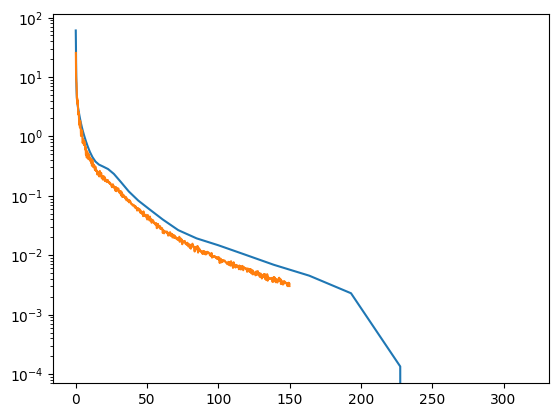

In [210]:
plt.semilogy(r, rho_los)
plt.semilogy(rad_emp, dvals_emp*Menc)


In [172]:
# Coefficients visualizations:


In [173]:
times = symphony_coef.time


In [174]:
surfaces.keys

<function dict.keys>

In [62]:
volume = np.zeros((50, 100, 100))
volume_mon = np.zeros((50, 100, 100))
volume_dip = np.zeros((50, 100, 100))

z_sice = np.linspace(-50, 50, 50)
for i in range(len(z_sice)):
    pmin  = [-150.0, -150.0, z_sice[i]]
    pmax  = [ 150.0,  150.0, z_sice[i]]
    grid  = [  100,   100,   0]
    
    fields = pyEXP.field.FieldGenerator([times], pmin, pmax, grid)
    surfaces = fields.slices(symphony_basis, halo_coefs)
    volume[i] = surfaces[0.0]['dens']
    volume_mon[i] = surfaces[0.0]['dens m=0']
    volume_dip[i] = surfaces[0.0]['dens m>0']
    

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pyEXP.field.FieldGenerator(times: List[float], lower: List[float], upper: List[float], gridsize: List[int])

Invoked with: [[0.0]], [-150.0, -150.0, -50.0], [150.0, 150.0, -50.0], [100, 100, 0]

In [182]:
import pickle

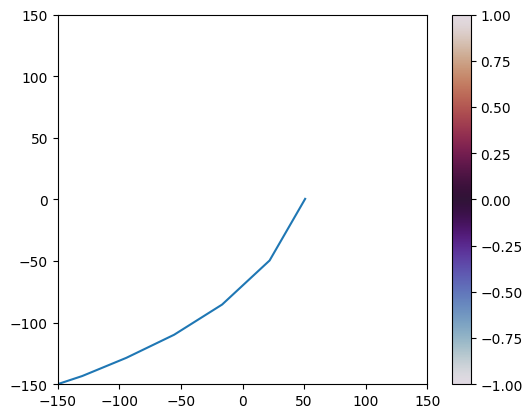

In [61]:
img = plt.imshow((np.mean(volume, axis=0)/ np.mean(volume_mon, axis=0)).T - 1  , cmap='twilight', 
                     origin='lower', extent=[-150, 150, -150, 150], vmin=-1, vmax=1)
plt.plot(orbits['Halo719'][:19,0], orbits['Halo719'][:19,1])
plt.colorbar(img)
plt.xlim(-150, 150)
plt.ylim(-150, 150)

plt.show()

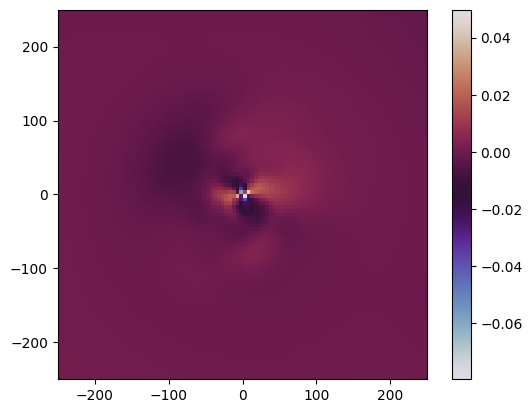

In [138]:


img = plt.imshow((np.mean(volume_dip, axis=0).T), cmap='twilight', 
                     origin='lower', extent=[-250, 250, -250, 250])
plt.colorbar(img)

plt.show()

/tmp/ipykernel_1299/1625451897.py:1: RuntimeWarning: invalid value encountered in log10
  img = plt.imshow(np.log10(np.mean(volume_mon, axis=0).T), cmap='twilight', vmin=-4, vmax=0,


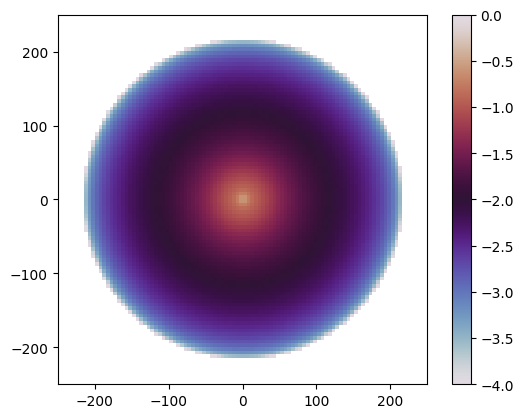

In [118]:
img = plt.imshow(np.log10(np.mean(volume_mon, axis=0).T), cmap='twilight', vmin=-4, vmax=0, 
                     origin='lower', extent=[-250, 250, -250, 250])
plt.colorbar(img)

plt.show()

In [22]:
# Analytic basis

In [24]:
EXPtools.basis_builder.makebasis(np.ones(nparticles), h['position'], basis_model='NFW', config=)

Signature:
EXPtools.basis_builder.makebasis(
    pos,
    mass,
    basis_model,
    config=None,
    basis_id='sphereSL',
    time=0,
    r_s=1.0,
    r_c=0.0,
    nbins=500,
    rmin=0.61,
    rmax=599,
    log_space=True,
    lmax=4,
    nmax=20,
    scale=1,
    norm_mass_coef=True,
    modelname='dens_table.txt',
    cachename='.slgrid_sph_cache',
    add_coef=False,
    coef_file='',
)
Docstring:
Create a BFE expansion for a given set of particle positions and masses.

Parameters:
pos (numpy.ndarray): The positions of particles. Each row represents one particle, 
                     and each column represents the coordinate of that particle.
mass (numpy.ndarray): The masses of particles. The length of this array should be the same 
                      as the number of particles.
basismodel (string): The model to compute, NFW,Hernquist, singlepowerlaw and empirical are available
                    A modelname file can be used to specify a particular model if needed.
config (py

In [ ]:

img = plt.imshow(np.log10(np.mean(volume, axis=0).T), cmap='twilight', vmin=-4, vmax=0, 
                     origin='lower', extent=[-250, 250, -250, 250])
plt.colorbar(img)

plt.show()

In [123]:
np.savetxt('Halo719_snap_241_density.txt', np.mean(volume, axis=0))

In [205]:
np.savetxt('Halo719_snap_241_density_mon.txt', np.mean(volume_mon, axis=0))

In [282]:
np.savetxt('Halo719_snap_241_density_dip_3.txt', np.mean(volume_dip, axis=0))